In [1]:
## Import all libraries needed

import pandas as pd
from urllib.request import urlopen
import json
import zipfile
import os
import shutil
import PyPDF2
import pandas as pd

## Import csv files

In [2]:
# We import csv files and save them as dataframe
train1 = pd.read_csv("train1.csv")
train2 = pd.read_csv("train2.csv",sep=";")

## Import json files

In [3]:
##Connect with the API and extract json files that we convert to dataframes

url = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first"
response = urlopen(url)
data = pd.read_json(response.read())
data.to_csv("train3.csv", index =False)

url = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second"
response = urlopen(url)
data = pd.read_json(response.read())
data.to_csv("train4.csv",index =False)

url = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
response = urlopen(url)
data = pd.read_json(response.read())
data.to_csv("train5.csv", index=False)

## Import pdf files

In [4]:
## We create a sequence of fucntions to obtain data of the pdf files

dirpath = "train6"

#extracting zip file
with zipfile.ZipFile("train6.zip", 'r') as zip_ref:
    zip_ref.extractall()
    
    
#dictionary that connects variable to position in the raw text
var_to_pos = {"FacilityInspireID": 6, 
            "CONTINENT": 10,
            "countryName": 8,
            "City": 12,
            "EPRTRSectorCode": 14,
            "eprtrSectorName": 16,
            "EPRTRAnnexIMainActivityCode": 18,
            "targetRelease": 20,
            "pollutant": 22,
            "DAY": 26,
            "MONTH": 28,
            "reportingYear": 30,
            "max_wind_speed": 35,
            "min_wind_speed": 33,
            "avg_wind_speed": 37,
            "max_temp": 41,
            "min_temp": 39,
            "avg_temp": 43,
            "DAY WITH FOGS": 45,
            "REPORTER NAME": 47,
            "CITY ID": 49}

def edit(text): 

#In the beginning we used this function to correct the x,xExx numbers.
#We later decided to not spend ore time figuring those numbers out since they were obviously corrupted

    do = False
    for t in text: 
        try:
            int(t)
            do = True
        except: pass
    if do: 
        result = text.replace(" ", "")
        if "E" in result:
            try: 
                num = result.split("E+")
                if num[-1] == "15": mult = 1 
                elif num[-1] == "16": mult = 10 
                result = float(num[0].replace(",", "."))*mult
            except:
                pass
        return result
    else: return text
    
def process(i, text):
    info = {}
    t = text.split("\n")
    x = 0
    if i > 0: x = 1
    info["facilityName"] = t[4]
    for var, pos in zip(var_to_pos, var_to_pos.values()):
        info[var] = edit(t[pos+x])
        
    return t[2], info

def tabulate_pdf_info():
    dirpath = "train6"
    total_info = {}
    for i, pdf_file in enumerate(os.listdir(dirpath)):

        pdfFileObj = open(dirpath+"/"+pdf_file, 'rb')
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

        # creating a page object
        pageObj = pdfReader.getPage(0)

        #calling process function
        idd, info = process(i, pageObj.extractText())

        #adding key and values to dictionary
        total_info[idd] = info

    #creating and transforming dataset
    df = pd.DataFrame(total_info).T
    df["countryName"] = df["countryName"].replace("United Kingdo m", "United Kingdom")
    df["CONTINENT"] = df["CONTINENT"].replace("EUROP E", "EUROPE")
    df = df.replace({"pollutant": {"Nitro gen o xides (NOX )": "Nitrogen oxides (NOX)", "Carbondioxide(CO2)":"Carbon dioxide (CO2)", "Methane(CH4)": "Methane (CH4)" }})
    
    return df

df = tabulate_pdf_info()
df.to_csv("train6.csv")

In [5]:
## Import all the data
train3 = pd.read_csv("train3.csv")
train4 = pd.read_csv("train4.csv")
train5 = pd.read_csv("train5.csv")
train6 = pd.read_csv("train6.csv")

In [6]:
## Creation of some dimension tables to cross registers and obtain same number of columns

Sector = pd.concat([train3[["EPRTRSectorCode", "eprtrSectorName"]], train4[["EPRTRSectorCode", "eprtrSectorName"]],train5[["EPRTRSectorCode", "eprtrSectorName"]]]).drop_duplicates()
City = pd.concat([train1[["CITY ID", "City"]], train2[["CITY ID", "City"]],train3[["CITY ID", "City"]], train4[["CITY ID", "City"]],train5[["CITY ID", "City"]]]).drop_duplicates()
Label = pd.concat([train3[["EPRTRAnnexIMainActivityLabel", "EPRTRAnnexIMainActivityCode"]], train4[["EPRTRAnnexIMainActivityLabel", "EPRTRAnnexIMainActivityCode"]], train5[["EPRTRAnnexIMainActivityLabel", "EPRTRAnnexIMainActivityCode"]]]).drop_duplicates()
Facility = pd.concat([train1[["FacilityInspireID", "facilityName"]], train2[["FacilityInspireID", "facilityName"]], train3[["FacilityInspireID", "facilityName"]], train4[["FacilityInspireID", "facilityName"]], train5[["FacilityInspireID", "facilityName"]]]).drop_duplicates()

In [7]:
## Merging some registers by its code and we save the final dataframe as csv file

train1 = train1.merge(Sector).merge(Label)
train2 = train2.merge(Sector).merge(Label)
train6 = train6.drop(columns=["facilityName", "City", "eprtrSectorName"])
train6 = train6.merge(City).merge(Sector).merge(Label) #merge(Facility)
    

df = pd.concat([train1,train2,train3,train4,train5,train6],ignore_index=True)
df = df.drop_duplicates()

codes, uniques = pd.factorize(df["pollutant"])
df["pollutant_code"] = codes
df["pollutant_code"]= df["pollutant_code"].replace(0,-1).replace(1,0).replace(-1,1)
df.to_csv('final_dataset.csv', index = False)

## Pandas_profiling, uncommend to obtain profile report in html format

In [8]:
#from pandas_profiling import ProfileReport
#prof = ProfileReport(df)
#prof.to_file(output_file='output.html')

## Imbalance target 

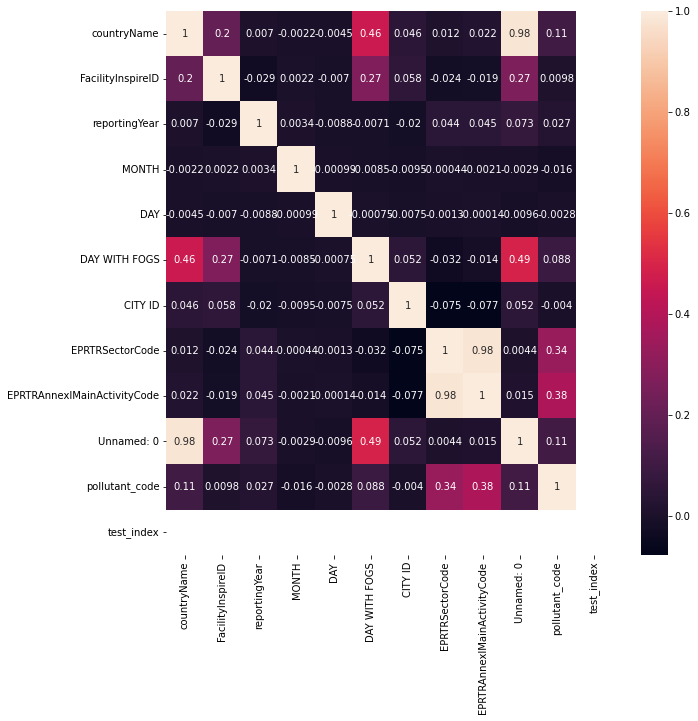

In [9]:
## Import SMOTE function to valance target variable, to avoid overfitting
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt
import seaborn as sn
import phik
from phik import resources, report

# Import final dataset and predictions dataset
df_train = pd.read_csv("final_dataset.csv", sep = ",")
df_test = pd.read_csv("test_x.csv", sep = ",")

# Create some variable to distinguish wich one is for train and wich is for testing
df_test["TRAIN/TEST"] = ["test" for i in range(0, len(df_test))]
df_train["TRAIN/TEST"] = ["train" for i in range(0, len(df_train))]
df_all = pd.concat([df_train,df_test],ignore_index=True)

from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'.
df_all = df_all.drop(columns=["targetRelease", "CONTINENT"])
df_all['countryName']= label_encoder.fit_transform(df_all["countryName"])
df_all['EPRTRSectorCode']= label_encoder.fit_transform(df_all['EPRTRSectorCode'])
df_all['EPRTRAnnexIMainActivityCode']= label_encoder.fit_transform(df_all['EPRTRAnnexIMainActivityCode'])
df_all['FacilityInspireID']= label_encoder.fit_transform(df_all['FacilityInspireID'])
df_all['CITY ID']= label_encoder.fit_transform(df_all['CITY ID'])

df = df_all[df_all["TRAIN/TEST"]=="train"]
df = df.drop(columns=["TRAIN/TEST"])

df_test = df_all[df_all["TRAIN/TEST"]=="test"]
df_test = df_test.drop(columns=["pollutant", "pollutant_code","TRAIN/TEST"])

## We obtain Pearson's correlation Matrix, but we obtain better visulaization with Phi_k correlation matrix 
## using pandas profiling tool 
corrMatrix = df.corr()
plt.figure(figsize=(10, 10))
sn.heatmap(corrMatrix, annot=True)
plt.show()


In [10]:
## Due to correlation analysis we select the variables that we think are more significative

X = df[["CITY ID","EPRTRSectorCode", "EPRTRAnnexIMainActivityCode", "countryName", "FacilityInspireID", "DAY WITH FOGS"]]
y = df["pollutant_code"]

sm = SMOTE(random_state=42)

## Apply SMOTE to avoid imbalance and overfitting
X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (57167, 6)
Shape of X after SMOTE: (67917, 6)

Balance of positive and negative classes (%):


2.0    33.333333
0.0    33.333333
1.0    33.333333
Name: pollutant_code, dtype: float64

## Random Forest Models

In [11]:
## We create a Random Forest Model
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

model = RandomForestClassifier(4000).fit(X_train, y_train)
model

RandomForestClassifier(n_estimators=4000)

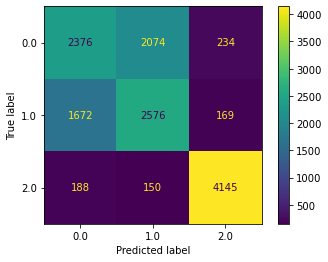

In [12]:
## Plot confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import confusion_matrix

predicted = model.predict(X_test)

plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [13]:
## Compute accuracy of the model

from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted)

0.6696849234393404

In [14]:
## Obtain precision, recall, f-score and support

from sklearn.metrics import classification_report

report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.56      0.51      0.53      4684
         1.0       0.54      0.58      0.56      4417
         2.0       0.91      0.92      0.92      4483

    accuracy                           0.67     13584
   macro avg       0.67      0.67      0.67     13584
weighted avg       0.67      0.67      0.67     13584



In [17]:
## Compute precidtion and saving it as .csv and .json

predicted = model.predict(df_test[["CITY ID","EPRTRSectorCode", "EPRTRAnnexIMainActivityCode", "countryName", "FacilityInspireID", "DAY WITH FOGS"]])

test = pd.DataFrame()
test["test_index"] = [int(i) for i in df_test["test_index"]]
test["pollutant"] = [int(i) for i in predicted]
test = test.set_index("test_index")
test.to_csv("predictions.csv" ,sep=";")
test.to_json("predictions.json")

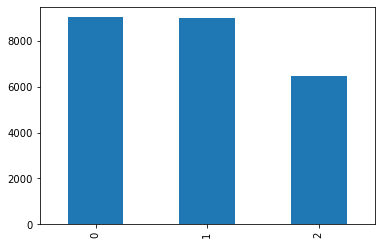

In [16]:
test['pollutant'].value_counts().plot(kind='bar');